# Assignment 1

## Submission Guidlines
- Sumbit you Assignmet to the [Submission System](https://cs-serv.cs.bgu.ac.il/cs_service/subsys.html) as a single *.ipynb file
- The submission is alone or in pairs
- Write only in English   
- When drawing graphs, you should add a title, you should also label the x and y axes

## Overview
In this Assignment, you will:

1. Implement local sequence alignment algorithm
2. Use your algoirthm to align a short protein sequence (**query**) with a very long protein sequence (**database**)
3. Analyze your results

## Submitting 
* Doron Har-Noy 204209209 
* Lev Gourevitch 314369547


## 1. Local Sequence Alignment Algorithm

Implement Local Sequence Alignment Algorithm that was studied in class (see first practical session for a reminder)

**Input:**

- Two amino-acid input sequences $S_1, S_2$
- A scoring matrix - can be found in the file *blosum_62.txt*
    - This is BLOSUM62 scroing matrix for proteins  
    The sign '\*' in a row or column represents indels score

**Output:**
- Optimal local alignment of $S_1, S_2$
- Optimal alignment score
- Start and end indices of the local alignment in $S_1$ and $S_2$
- The Dynamic Programming table after the computation is done

For example, local alignment of:  

In [1]:
s1 = 'YVEGLKMF'  
s2 = 'ELGLMBAR'

should return the following output:

In [2]:
print('\n'.join(['E_GLKM','ELGL_M','score = 12','s1 (2, 7)','s2 (0, 5)']))

E_GLKM
ELGL_M
score = 12
s1 (2, 7)
s2 (0, 5)


You don't need to print the dynamic programming table, but keep it for part 2

In this example, the optimal local alignment is between **seq1[2:7]** and **seq2[0:5]** (the last index is not included)

In [3]:
print(s1[2:7])
print(s2[0:5])

EGLKM
ELGLM


### 1.1 Implementation of the Seq. align alg.

In [4]:
import pandas as pd
import numpy as np
import functools

# Enable this if you want a for loop with progress bar:
# from tqdm import tqdm_notebook   

In [5]:
def get_blosom_dict_from_file() -> pd.DataFrame:
    with open("blosum_62.txt") as f:
        lines = f.readlines()
        table_lines = filter(lambda l: not l.startswith('#'), lines)
        no_endl_lines = map(str.rstrip, table_lines)
        split_lines = list(map(str.split, no_endl_lines))
        
        df = pd.DataFrame(split_lines[1:])
        df = df.set_index(df.columns[0])
        df.columns = split_lines[0]
        df = df.applymap(int)
        
        # convert to dict for much faster lookup times
        score_dict = {}
        for r in df.index:
            for c in df.index:
                score_dict[(r, c)] = df.loc[r, c]
        
        return score_dict

    
def load_seq_from_file(filname: str) -> str:
    with open(filname) as f:
        lines = f.readlines()[1:]
        no_endl_lines = map(str.rstrip, lines)
        return ''.join(no_endl_lines)
    

def run_alg(matrix, seq_str, db_str, sub_dict):
    max_score = -1
    max_score_coord = (-1, -1)

    for row in range(1, len(seq_str)):
        
# replace the for above with this one to see progress bar
#    for row in tqdm_notebook(range(1, len(seq_str)), desc='rows'):
        for col in range(1, len(db_str)):
            matrix[row, col] = max(
                matrix[row - 1, col] + sub_dict[(seq_str[row - 1], '*')],
                matrix[row, col - 1] + sub_dict[('*', db_str[col - 1])],
                matrix[row - 1, col - 1] + sub_dict[(seq_str[row - 1], db_str[col - 1])],
                0
            )
    
            if matrix[row, col] > max_score:
                max_score = matrix[row, col]
                max_score_coord = (row, col)
                
    return max_score, max_score_coord       


def get_alignment_s1_s2(matrix, seq_str, db_str, sub_dict, row_max, col_max):
    s1_align_reconstruction = []
    s2_align_reconstruction = []
    
    while matrix[row_max, col_max]:
        if matrix[row_max - 1, col_max] + sub_dict[(seq_str[row_max - 1], '*')] == matrix[row_max, col_max]:
            s1_align_reconstruction.append(seq_str[row_max - 1])
            s2_align_reconstruction.append('_')
            row_max -= 1
        
        elif matrix[row_max, col_max - 1] + sub_dict[('*', db_str[col_max - 1])] == matrix[row_max, col_max]:
            s2_align_reconstruction.append(db_str[col_max - 1])
            s1_align_reconstruction.append('_')
            col_max -= 1
            
        else:
            s1_align_reconstruction.append(seq_str[row_max - 1])
            s2_align_reconstruction.append(db_str[col_max - 1])
            row_max -= 1
            col_max -= 1
            
    s1_align = ''.join(reversed(s1_align_reconstruction))
    s2_align = ''.join(reversed(s2_align_reconstruction))
    
    return s1_align, s2_align


def find_coords_of_align(seq_str, s1_align, db_str, s2_align):
    s1_align_clean, s2_align_clean = s1_align.replace('_', ''), s2_align.replace('_', '')
    s1_index = seq_str.find(s1_align_clean)
    s2_index = db_str.find(s2_align_clean)
    
    return (s1_index, s1_index + len(s1_align_clean)), (s2_index, s2_index + len(s2_align_clean))


def pretty_alignment_lines(s1, s2):
    all_lines = []
    while s1:
        first_line = s1[:120]
        second_line = s2[:120]
        middle_line = map(lambda t: '|' if '_' not in [t[0], t[1]] else ' ', zip(first_line, second_line))
        middle_line_str = ''.join(middle_line)

        all_lines = [*all_lines, first_line, middle_line_str, second_line, '']

        s1 = s1[120:]
        s2 = s2[120:]
        
    return all_lines


def print_align_results(matrix, max_score, row_max, col_max, seq_str, db_str, sub_dict):
    s1_align, s2_align =  get_alignment_s1_s2(matrix, seq_str, db_str, 
                                              sub_dict, row_max, col_max)
    
    alignment_lines = pretty_alignment_lines(s1_align, s2_align)
    
    s1_coords, s2_coords = find_coords_of_align(seq_str, s1_align, db_str, s2_align)
    
    [print(l) for l in alignment_lines]
    print(
        f'score = {max_score}\n'
        f's1 {s1_coords}\n'
        f's2 {s2_coords}\n'
        )


In [6]:
blosum_dict = get_blosom_dict_from_file()
seq_str = load_seq_from_file('seq1.fasta')
db_str = load_seq_from_file('seq2.fasta')

print(f'seq len: {len(seq_str)}, db len:  {len(db_str)}')

seq len: 1382, db len:  101352


In [7]:
# Sanity test:
"""
E_GLKM
ELGL_M
score = 12
s1 (2, 7)
s2 (0, 5)
"""

test_matrix = np.zeros([len(s1), len(s2)])
max_score, max_score_coord = run_alg(test_matrix, s1, s2, blosum_dict)

print_align_results(test_matrix, max_score,
                    max_score_coord[0], max_score_coord[1],
                    s1, s2, blosum_dict)


E_GLKM
| || |
ELGL_M

score = 12.0
s1 (2, 7)
s2 (0, 5)



## 2. Running the algorithm and analyzing the results

In this section, you will run your algorithm on the sequences from *seq1.fasta* and *seq2.fasta* files

**Input:**

- **query** protein: The file *seq1.fasta* contains a single protein:  
    The first line starts with '>' and the name of the sequecne.  
    The concatenation of all lines that come after '>' is the sequence itself.

- **database**: The file *seq2.fasta* contains a very long sequence of amino acids, representing a database of proteins (same format as *seq1.fasta*)
- A scoring matrix - can be found in the file blosum_62.txt

> Note: In the Dynamic Programming table, the **query** should be represented by the **rows** and the **database** should be represented by the **columns**

Execute local alignment of the query against the database and **report**:
- Optimal alignment of query and database
- Optimal alignment score
- Start and end indices of the local alignment in **query** and **database**
- Runtime performance

In [8]:
%%time
#report your results here

align_matrix = np.zeros([len(seq_str), len(db_str)])
max_score, max_score_coord = run_alg(align_matrix, seq_str, db_str, blosum_dict)


CPU times: user 5min 24s, sys: 38 s, total: 6min 2s
Wall time: 6min 3s


In [9]:
print_align_results(align_matrix, max_score, 
                    max_score_coord[0], max_score_coord[1],
                    seq_str, db_str, blosum_dict)

AVAALLLGAA_GHLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDFRDLSFPKLIMITDYLLLFRVYGLESLKDLFPNLTVIRGSRLFFNYALVIFEMVHLKELGLYN
|||||||||| | |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
AMACLLTCLAFG_LFLLLVCPGMDIRNNLTRLHELANCSVIEGHLQILLMFKTRPEDFRDLSFPKLIMITDYLLLFRVYGLESLKDLFPNLTVIRGSRLFFNYALVIFEMVHLKELGLYS

LMNITRGSVRIEKNNELCYLATIDWSRILDSVEDNYIVLNKDDNEECGDICPGTAKGKTNCPATVINGQFVERCWTHSHCQKVCPTICKSHGCTAEGLCCHSECLGNCSQPDDPTKCVAC
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
LMNITRGSVRIEKNNELCYLATIDWSRILDSVEDNYIVLNKDDNEECGDICPGTAKGKTSCPATVINGQFVERCWTHSHCQKVCPTICKSHGCTSEGLCCHSECLGNCSEPDDPTKCVAC

RNFYLDGRCVETCPPPYYHFQDWRCVNFSFCQDLHHKCKNSRRQGCHQYVIHNNKCIPECPSGYTMNSSNLLCTPCLGPCPKVCHLLEGEKTIDSVTSAQELRGCTVINGSLIINIRGGN
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
RNFYLDGRCVETCPPPYYHFQDWRCVNFSF

## Questions

Answer the 6 questions below:

1. What protein sequence will get the highest possible score when aligned against the **query** (using Local Alignment and the given scoring matrix)? Compute this score.

### Answer:  
Because we see that each letter gets the highest score when "replaced"
by itself - the highest score will be computed if the **query** is aigned
with a string **S** such as **query** is part of **S**.

In [10]:
#compute the score here
align_matrix_opt = np.zeros([len(seq_str), len(seq_str)])
max_score_opt, max_score_coord = run_alg(align_matrix_opt, seq_str, seq_str, blosum_dict)

print(f'Max score: {max_score_opt},'
      f' %of optimal score: [{(max_score / max_score_opt) * 100}%]')

Max score: 7424.0, %of optimal score: [94.05980603448276%]


2. What is the optimal score of a local alignment between query and database, in comparison to the score computed in (1)? What can you conclude? 

### Answer:  
We can see that the alignment score is 94% of the optimal score.
Thus we can conclude that the quality of the alignment is very high
(Very high similiraty)

3. Plot a heatmap of the dynamic programming table, using [matplotlib.pyplot.imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html), for example:

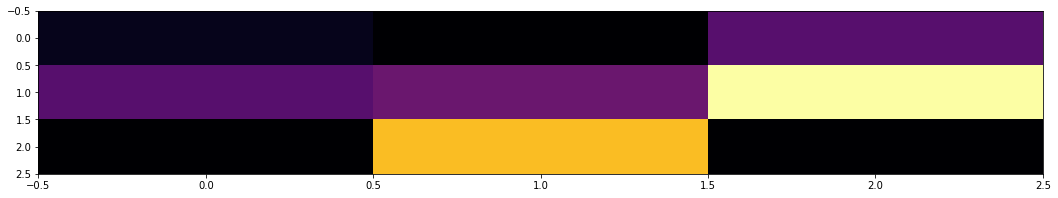

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

matrix = [[1, 0, 5],
          [5, 6, 20],
          [0, 17, 0]]
plt.figure(figsize=(18,3))
plt.imshow(matrix, aspect='auto', cmap='inferno')

It is recommended you use figure size and color map from this example

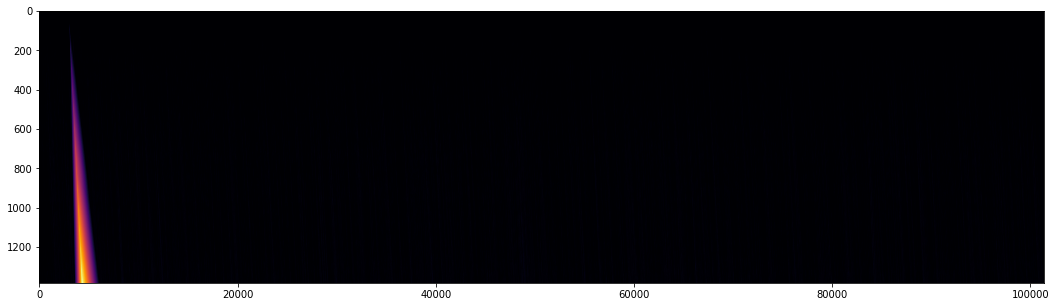

In [12]:
#plot heatmap here
plt.figure(figsize=(18,5))
plt.imshow(align_matrix, aspect='auto', cmap='inferno')

4. What can you tell from this heatmap about the query and the database?

### Answer:  
We can see that there is only a very narrow "corridor" with positive values - meaning that we could skip calculation for most of the alignment matrix.

5. Run a [BlastP](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE=Proteins) search (Blast for proteins) using the query. Just copy the sequence into the input box and press on 'BLAST' button. What did you get?
 

### Answer:  
We found a **100% match** with - insulin receptor isoform Long preproprotein [Homo sapiens]

6. Run BlastP on the **database[start:end]** where start is the first index of the optimal alignment and end is the end index of the alignment. What did you get?

### Answer:  
We found 100% match with - PREDICTED: insulin receptor isoform X3 [Mustela putorius furo]
We can suspect that this prediction was made by comparing to the sequence we've queried before (or by a one similar to it)